In [178]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [179]:
# Carga de las carpetas de imagenes con tumores y sin tumor de las resonancias magenticas
resonancia = 'brain_tumor_dataset' # Carga de la carperta de resonancias 

In [180]:
# Carga de las carpetas de imagenes con tumores y sin tumor de las resonancias magenticas
tumor = os.listdir('yes') # Carga de la carpeta de tumores
no_tumor = os.listdir('no') # Carga de la carperta de resonancias sin tumores

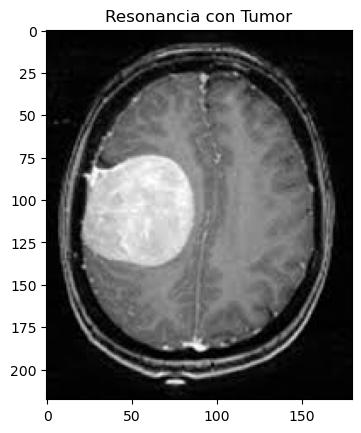

In [181]:
imagen_path_tumor = os.path.join('yes', tumor[0]) 
# os.path.join lo usamos para poder unir dos componentes de ruta, en este caso unimos la carpeta 'yes' con el primer elemento de 
# de la lista tumor.

imagen_tumor = cv2.imread(imagen_path_tumor)
# leemos la imagen desde la ruta del achivo 
plt.imshow(cv2.cvtColor(imagen_tumor, cv2.COLOR_BGR2RGB))
plt.title('Resonancia con Tumor')
plt.show()

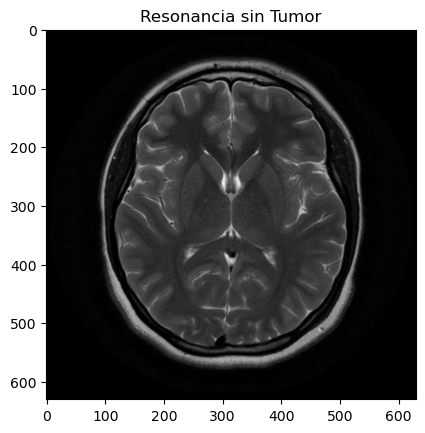

In [182]:
imagen_path_no_tumor = os.path.join('no', no_tumor[0]) 
# os.path.join lo usamos para poder unir dos componentes de ruta, en este caso unimos la carpeta 'yes' con el primer elemento de 
# de la lista tumor.

imagen_no_tumor = cv2.imread(imagen_path_no_tumor)
# leemos la imagen desde la ruta del achivo 
plt.imshow(cv2.cvtColor(imagen_no_tumor, cv2.COLOR_BGR2RGB))
plt.title('Resonancia sin Tumor')
plt.show()

### Modificacion de la base de datos de Resonancia

In [183]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar los valores de píxeles
    rotation_range=20,  # Rotación aleatoria de hasta 20 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    shear_range=0.2,  # Corte aleatorio
    zoom_range=0.2,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal aleatorio
    fill_mode='nearest'  # Rellenar los píxeles fuera de los límites
)

Found 253 images belonging to 2 classes.


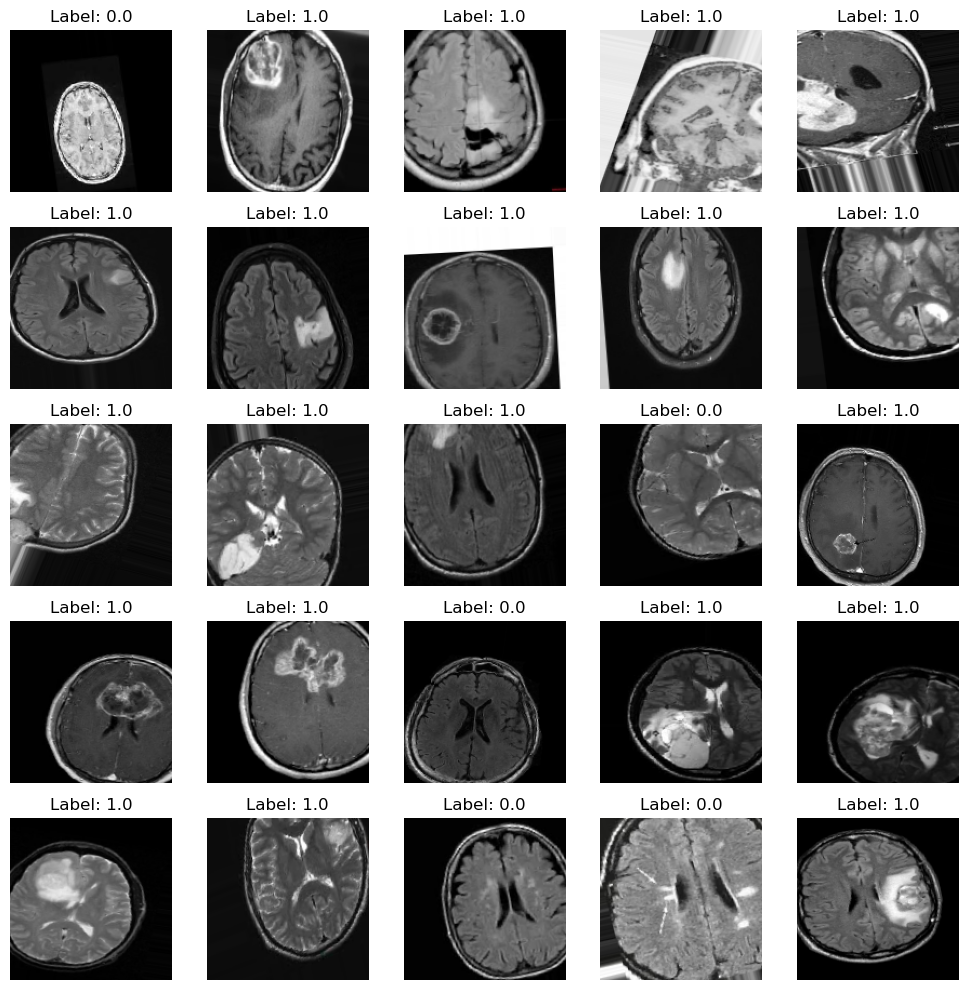

In [184]:
image_generator = datagen.flow_from_directory(
    resonancia,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')
def plot_images(images, titles):
    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


images, labels = next(image_generator)
plot_images(images, [f'Label: {label}' for label in labels])

### Filtros

In [185]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    resonancia,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 253 images belonging to 2 classes.


In [186]:
def apply_filters_and_convolutions(image):
    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Aplicar un filtro de desenfoque (blur)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Aplicar un filtro de detección de bordes (Sobel)
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

    # Aplicar un filtro de convolución personalizado
    kernel = np.array([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]])
    custom_convolution = cv2.filter2D(gray_image, -1, kernel)

    return gray_image, blurred_image, sobel_combined, custom_convolution

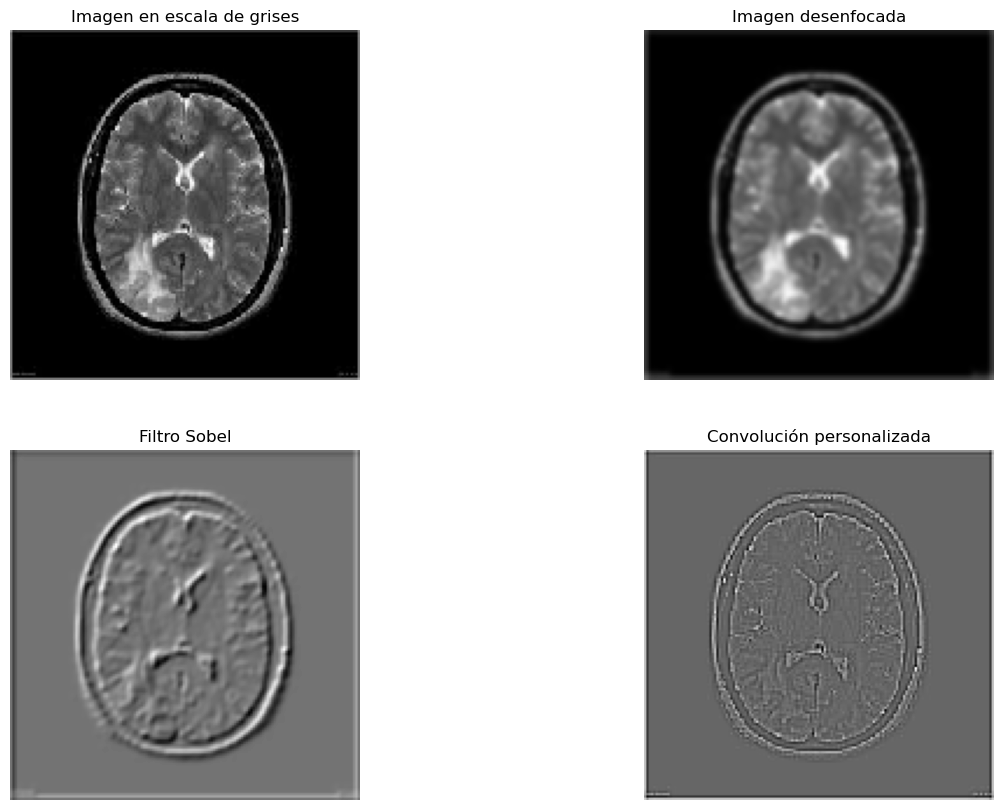

In [187]:
def display_images(images, titles):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

images, _ = next(train_generator)

# Aplicar filtros y convoluciones a la primera imagen del batch
gray_image, blurred_image, sobel_combined, custom_convolution = apply_filters_and_convolutions(images[0])

# Mostrar las imágenes resultantes
display_images([gray_image, blurred_image, sobel_combined, custom_convolution],
               ['Imagen en escala de grises', 'Imagen desenfocada', 'Filtro Sobel', 'Convolución personalizada'])

### Modelo

In [188]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')



In [194]:
X = tumor
y = no_tumor

X = X[:97]
y = y[:97]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [197]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

X_train = np.array([img_to_array(load_img(path, target_size=(150, 150))) for path in no_tumor])
X_train = X_train / 255.0 

FileNotFoundError: [Errno 2] No such file or directory: '1 no.jpeg'

In [195]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [196]:
###Entrenar modelo

batch_size= 90
epochs = 10 

history = model.fit(
X_train, y_train,
batch_size=batch_size,
epochs=epochs,
)

ValueError: Unrecognized data type: x=['Y180.jpg', 'Y243.JPG', 'Y24.jpg', 'Y113.JPG', 'Y163.JPG', 'Y158.JPG', 'Y107.jpg', 'Y252.jpg', 'Y109.JPG', 'Y21.jpg', 'Y32.jpg', 'Y155.JPG', 'Y153.jpg', 'Y259.JPG', 'Y103.jpg', 'Y169.jpg', 'Y242.JPG', 'Y16.JPG', 'Y114.JPG', 'Y245.jpg', 'Y159.JPG', 'Y105.jpg', 'Y186.jpg', 'Y15.jpg', 'Y117.JPG', 'Y251.JPG', 'Y147.JPG', 'Y184.JPG', 'Y111.JPG', 'Y146.JPG', 'Y101.jpg', 'Y115.JPG', 'Y162.jpg', 'Y106.jpg', 'Y249.JPG', 'Y104.jpg', 'Y250.jpg', 'Y160.JPG', 'Y257.jpg', 'Y187.jpg', 'Y33.jpg', 'Y185.jpg', 'Y167.JPG', 'Y181.jpg', 'Y22.jpg', 'Y17.jpg', 'Y23.JPG', 'Y194.jpg', 'Y31.jpg', 'Y25.jpg', 'Y165.JPG', 'Y19.JPG', 'Y18.JPG', 'Y256.JPG', 'Y188.jpg', 'Y157.JPG', 'Y29.jpg', 'Y192.JPG', 'Y2.jpg', 'Y28.jpg', 'Y161.JPG', 'Y154.jpg', 'Y10.jpg', 'Y183.jpg', 'Y120.JPG', 'Y100.JPG', 'Y14.jpg', 'Y26.jpg', 'Y247.JPG', 'Y258.JPG', 'Y254.jpg', 'Y12.jpg', 'Y193.JPG', 'Y244.JPG', 'Y112.JPG', 'Y3.jpg', 'Y182.JPG'] (of type <class 'list'>)

Entrenando con Adam...
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5093 - loss: 1.1546
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5625 - loss: 0.6558
Epoch 3/5


c:\Users\Usuario\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6167 - loss: 0.6485
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6875 - loss: 0.5543
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6516 - loss: 0.6306
Entrenando con SGD...
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7245 - loss: 0.5918
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6875 - loss: 0.6179
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7057 - loss: 0.6033
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 0.6437  
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 874ms/step - accuracy: 0.6653 - loss: 0.5984
Entrenando con RMSprop...
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5819 - loss: 0.7337  
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7188 - loss: 0.6172  
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 871ms/step - accuracy: 0.6586 - loss: 0.6304
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0

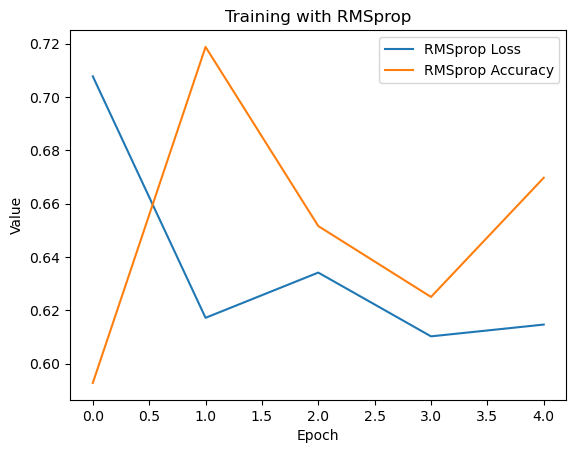

In [95]:
optimizers = {
'Adam': tf.keras.optimizers.Adam(),
'SGD': tf.keras.optimizers.SGD(),
'RMSprop': tf.keras.optimizers.RMSprop()
}

def train_model_with_optimizer(optimizer, epochs=5):
    model.compile(optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])

    history = model.fit(
    image_generator,
    steps_per_epoch=image_generator.samples // image_generator.batch_size,
    epochs=epochs
    )

    return history

for opt_name, optimizer in optimizers.items():
    print(f"Entrenando con {opt_name}...")
    history = train_model_with_optimizer(optimizer)

plt.plot(history.history['loss'], label=f'{opt_name} Loss')
plt.plot(history.history['accuracy'], label=f'{opt_name} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title(f'Training with {opt_name}')
plt.legend()
plt.show()

Found 253 images belonging to 2 classes.


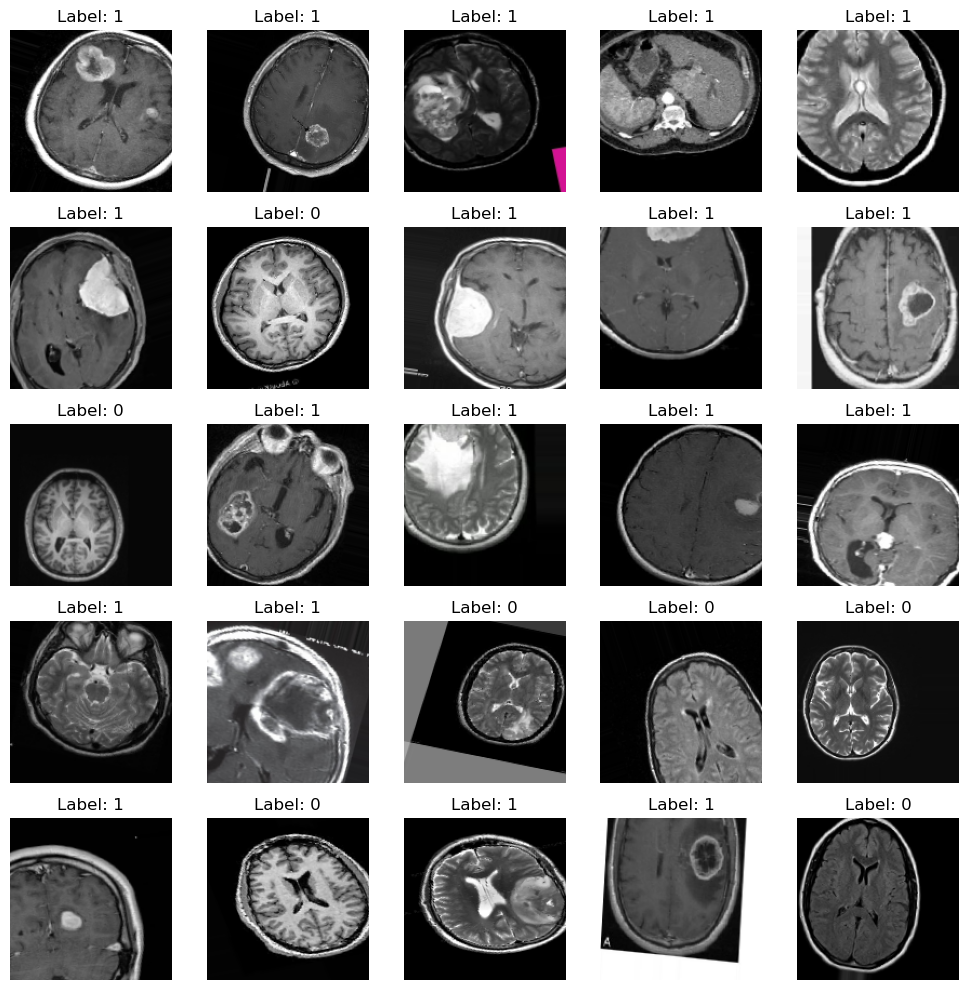


🧪 Entrenando con Adam...
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 930ms/step - accuracy: 0.4971 - loss: 1.2686
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5862 - loss: 0.6656  
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6300 - loss: 0.6661
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5312 - loss: 0.7136
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5718 - loss: 0.6628

🧪 Entrenando con SGD...
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 879ms/step - accuracy: 0.6276 - loss: 0.6824
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5625 - loss: 0.6822  
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 873ms/step - accuracy: 0.5904 - loss: 0.6662
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6250 - loss: 0.6677  
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 843ms/step - accuracy: 0.6216 - loss: 0.6537

🧪 Entrenando con RMSprop...
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 809ms/step - accuracy: 0.5144 - loss: 1.5100
Epoch 2/5
7/7

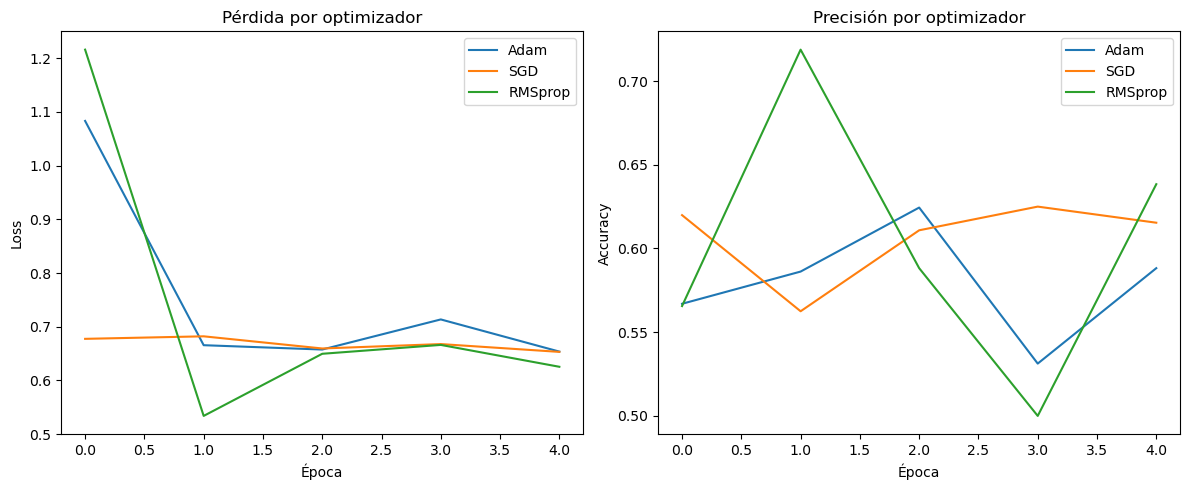

In [96]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

image_dir = 'brain_tumor_dataset'
output_dir = 'prueba'
os.makedirs(output_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

def plot_images(images, titles):
    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(image_generator)
plot_images(images, [f'Label: {int(label)}' for label in labels])

# --- Optimizers a comparar ---
optimizers = {
    'Adam': tf.keras.optimizers.Adam(learning_rate=0.001),
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.01),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001)
}

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

histories = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n🧪 Entrenando con {opt_name}...")

    model = create_model()
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        image_generator,
        steps_per_epoch=image_generator.samples // image_generator.batch_size,
        epochs=5,
        verbose=1
    )

    histories[opt_name] = history

plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
for name, history in histories.items():
    plt.plot(history.history['loss'], label=name)
plt.title('Pérdida por optimizador')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=name)
plt.title('Precisión por optimizador')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [108]:
X = tumor
y = no_tumor

X = X[:98]
y = y[:98]


In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)